In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from get_features import *

In [2]:
def unique_stations(df):
    '''
    Given a dataframe, identify the unique start/end stations
    
    INPUT: DataFrame
    OUTPUT: 1 array of unique start station ids
  
    '''
    #names of each start station and the number of trips 
    lst_start_station_name = df.start_station_name.value_counts()
    
    #ids of each start station and the number of trips 
    lst_start_station_id = df.start_station_id.value_counts()
    num_unique_stations = lst_start_station_id.unique().size
    unique_start_sations = df.start_station_id.unique()
    unique_end_stations = df.end_station_id.unique()
    return unique_start_sations
    

In [ ]:
df = pd.read_csv('data/201803-fordgobike-tripdata.csv')
mar_18_sf = model_city(df)
mar_18= unique_stations(mar_18_sf)
np.sort(mar_18)

In [ ]:
df = pd.read_csv('data/201804-fordgobike-tripdata.csv')
apr_18_sf = model_city(df)
apr_18= unique_stations(apr_18_sf)
np.sort(apr_18)

In [3]:
def new_stn_ids(old_stn, new_stn):
    '''
    INPUT: 2 lists. 1 list of new station ids
                    1 list of old station ids
    '''
    new_stn = set(new_stn) - set(old_stn)
    lst_new = list(new_stn)
    return lst_new



In [ ]:
proposed_stn = new_stn_ids(mar_18, apr_18)
proposed_stn

In [4]:
df_2017 = pd.read_csv('data/2017-fordgobike-tripdata.csv')
df_2017 = feature_addition(df_2017)


In [68]:
df = pd.read_csv('data/2018-2019-fordgobike-tripdata.csv')

In [69]:
df = feature_addition(df)

In [33]:
df_2018 = pd.read_csv('data/201804-fordgobike-tripdata.csv')
df_2018 = feature_addition(df_2018)

In [5]:
#separate the months
#cdf will be current month
#ndf will be next month
cdf = month_sep(df_2017, 2017, 11)
ndf = month_sep(df_2017, 2017, 12)

In [7]:
#find the unique stations for each month
cus = unique_stations(cdf)
nus = unique_stations(ndf)

In [8]:
#list of proposed stations
#stations opened in next month but not in current month
ps = new_stn_ids(cus, nus)

In [9]:
ps

[258, 292, 293, 294, 263, 267, 268, 237, 269, 337, 338, 339, 340, 254]

In [10]:
def stn_id_coords(df):
    #getting the coordinates from the dataset
    coordinates = np.array(df[['start_station_longitude', 'start_station_latitude']])
    unique_coords = np.unique(coordinates, axis = 0)
    #create a dictionary with
    #station id as key
    #coordinates for the station id as values
    id_coord = {}
    for u in unique_coords:
        k = df.start_station_id[(df.start_station_longitude == u[0]) &(df.start_station_latitude == u[1])].iloc[0]
        id_coord[k] = u
    return id_coord




In [14]:
def plot_new_station(df, new_stn):
#     print("The origin station is {}.".format(t))
#     print("The 3 closest neighbors are: {}, {}, {}".format(int(knn_dict.get(t)[0]),int(knn_dict.get(t)[1]),int(knn_dict.get(t)[2])))
    id_coord = stn_id_coords(df)
    plt.figure(figsize = (10,10))
    ll,rr = -122.50, -122.36
    bb = 37.73
    plt.xlim(ll,rr)
    plt.ylim(bb, bb+(rr-ll))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Map of Ford GoBike stations at the end of April 2018")
    plt.scatter(df.start_station_longitude, df.start_station_latitude, s=1, c=('r'))
    for n in new_stn:
#         if id_coord.get(n) is not None:
        plt.scatter(id_coord.get(n)[0], id_coord.get(n)[1], s=20, marker='x', c=('b'))
#         else:
#             print ("Station {} has been removed.".format(n))

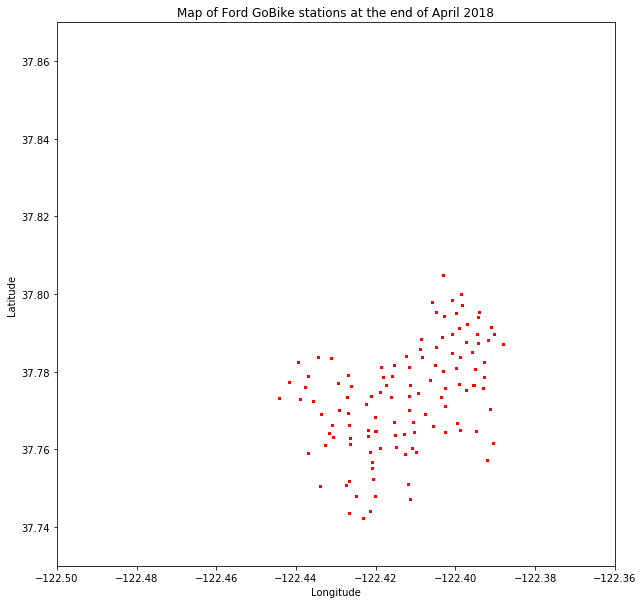

In [15]:
plot_new_station(ndf, ps)

In [16]:
ps

[258, 292, 293, 294, 263, 267, 268, 237, 269, 337, 338, 339, 340, 254]

### Use knn to pick stations from current month that are closest to each proposed station

In [21]:
def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

In [22]:
def knn_proposed_stn(df, df2, proposed_stn, num_neighbors = 3):
    

    coordinates = np.array(df[['start_station_longitude', 'start_station_latitude']])
    unique_coords = np.unique(coordinates, axis = 0)
    #get the id and coords for current month
    id_coord_df = stn_id_coords(df)
    id_coord_df2 = stn_id_coords(df2)
    knn_dict = {}
    for p in proposed_stn:
        neighbors = unique_coords[np.argsort(euclidean_distance(id_coord_df2.get(p), unique_coords))][1:num_neighbors+1]
#         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        v = []
        for i in range(num_neighbors):
            knn_id = df.start_station_id[(df.start_station_longitude == neighbors[i][0]) &(df.start_station_latitude == neighbors[i][1])].iloc[0]
            v.append(knn_id)
        knn_dict[p] = v
    return knn_dict

In [23]:
knn_proposed_stn(cdf, ndf, ps)

{258: [244, 247, 246],
 292: [290, 304, 289],
 293: [307, 308, 283],
 294: [287, 327, 208],
 263: [270, 259, 251],
 267: [240, 243, 248],
 268: [266, 274, 18],
 237: [228, 227, 226],
 269: [266, 248, 239],
 337: [182, 183, 181],
 338: [162, 202, 183],
 339: [186, 201, 162],
 340: [169, 188, 274],
 254: [238, 245, 246]}

### Time series by day

In [36]:
#3 month history for specific station
#current month and 2 previous month
cm = cdf.month.unique()[0]
tsdf = df_2017[(df_2017.month <=cm) & (df_2017.month>cm-3)]


In [37]:
tsdf.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_birth_year,member_gender,day_of_week,date,year,month,day,hour,malfunction,age
83695,76635,2017-11-30 19:54:03.465,2017-12-01 17:11:19.3150,120,Mission Dolores Park,37.76142,-122.426435,28,The Embarcadero at Bryant St,37.787168,...,NaN,NaN,3,2017-11-30,2017,11,30,19,False,NaN
84835,58723,2017-11-30 19:53:27.124,2017-12-01 12:12:10.2220,120,Mission Dolores Park,37.76142,-122.426435,44,Civic Center/UN Plaza BART Station (Market St ...,37.781074,...,NaN,NaN,3,2017-11-30,2017,11,30,19,False,NaN


In [38]:
months = np.sort(tsdf.month.unique())

In [39]:
months

array([ 9, 10, 11])

In [40]:
days = np.zeros(1)
days

array([0.])

In [41]:
for idx, mon in enumerate(months):
    mult = idx+1
    

In [42]:
tsdf['days'] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
tsdf['days'][tsdf.month == 11] = tsdf.day * 2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
def days_for_ts(df, cdf):
    cm = cdf.month.unique()[0]
    tsdf = df_2017[(df_2017.month <=cm) & (df_2017.month>cm-3)]
    tsdf['days'] = 1
    months = np.sort(tsdf.month.unique())
    for idx, mon in enumerate(months):
        mult = idx+1
        tsdf['days'][tsdf.month == mon] = tsdf.day * mult
    return tsdf

In [45]:
ts = days_for_ts(df_2017, cdf)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
ts['days'][ts.end_station_id == 246]

88376     90
88463     90
88689     90
89337     90
90916     87
91124     87
91594     87
92735     87
92738     87
93640     87
95826     84
96284     84
96872     84
96873     84
96919     84
96966     84
97256     84
97279     84
97282     84
97823     84
98408     84
98853     84
100449    81
101251    81
101335    81
101841    81
102479    81
103554    78
104887    75
105047    75
          ..
380323     5
380800     4
380839     4
380868     4
380889     4
381066     4
381068     4
381555     4
381677     4
381732     4
381866     4
381867     4
381996     4
381997     4
382154     4
382856     3
383810     3
384143     3
386679     1
386748     1
386749     1
386857     1
387071     1
387072     1
387969     1
387985     1
388248     1
388396     1
389006     1
389555     1
Name: days, Length: 488, dtype: int64

In [65]:
def plt_stn(df, station_id):
    tsplt = df['days'][df.end_station_id == station_id].value_counts().reset_index()
    tsplt = np.array(tsplt)
    tsplt = tsplt[np.argsort(tsplt[:,0])]
    plt.plot(tsplt[:,0], tsplt[:,1])


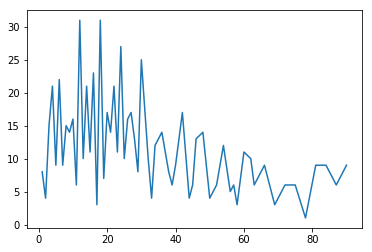

In [67]:
plt_stn(ts, 248)

In [54]:
ok = ts['days'][ts.end_station_id == 240].value_counts().reset_index()

In [61]:
ok = np.array(ok)
ok

array([[12, 27],
       [15, 20],
       [ 8, 19],
       [20, 18],
       [36, 18],
       [27, 17],
       [28, 16],
       [ 6, 16],
       [26, 15],
       [42, 14],
       [ 9, 14],
       [ 2, 14],
       [22, 14],
       [18, 14],
       [16, 14],
       [60, 14],
       [24, 13],
       [30, 13],
       [62, 12],
       [10, 12],
       [56, 11],
       [46, 10],
       [57, 10],
       [ 3, 10],
       [54, 10],
       [ 5, 10],
       [17, 10],
       [63, 10],
       [40,  9],
       [23,  9],
       [14,  9],
       [48,  9],
       [ 4,  7],
       [21,  7],
       [11,  7],
       [90,  7],
       [32,  7],
       [58,  7],
       [87,  6],
       [33,  6],
       [19,  6],
       [34,  6],
       [38,  6],
       [81,  6],
       [44,  6],
       [50,  5],
       [52,  5],
       [72,  5],
       [ 7,  5],
       [ 1,  5],
       [13,  5],
       [75,  4],
       [29,  3],
       [39,  3],
       [25,  3],
       [51,  2],
       [66,  2],
       [78,  2],
       [84,  2

In [62]:
ok[np.argsort(ok[:,0])]

array([[ 1,  5],
       [ 2, 14],
       [ 3, 10],
       [ 4,  7],
       [ 5, 10],
       [ 6, 16],
       [ 7,  5],
       [ 8, 19],
       [ 9, 14],
       [10, 12],
       [11,  7],
       [12, 27],
       [13,  5],
       [14,  9],
       [15, 20],
       [16, 14],
       [17, 10],
       [18, 14],
       [19,  6],
       [20, 18],
       [21,  7],
       [22, 14],
       [23,  9],
       [24, 13],
       [25,  3],
       [26, 15],
       [27, 17],
       [28, 16],
       [29,  3],
       [30, 13],
       [32,  7],
       [33,  6],
       [34,  6],
       [36, 18],
       [38,  6],
       [39,  3],
       [40,  9],
       [42, 14],
       [44,  6],
       [45,  1],
       [46, 10],
       [48,  9],
       [50,  5],
       [51,  2],
       [52,  5],
       [54, 10],
       [56, 11],
       [57, 10],
       [58,  7],
       [60, 14],
       [62, 12],
       [63, 10],
       [66,  2],
       [72,  5],
       [75,  4],
       [78,  2],
       [81,  6],
       [84,  2],
       [87,  6